In [7]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.layers import Input

import tensorflow as tf
import random
import itertools
import pandas as pd

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)




/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
def mackey_glass(total_time, beta, gamma, n, tau, x0):
    t = np.arange(0, total_time)
    x = np.zeros(total_time)
    x[0] = x0

    for t_step in range(1, total_time - 1):
        t_delay = t_step - tau
        x_tau = x[t_delay] if t_delay >= 0 else 0.0
        x[t_step + 1] = x[t_step] + (beta * x_tau / (1 + x_tau ** n) - gamma * x[t_step])
    return t, x

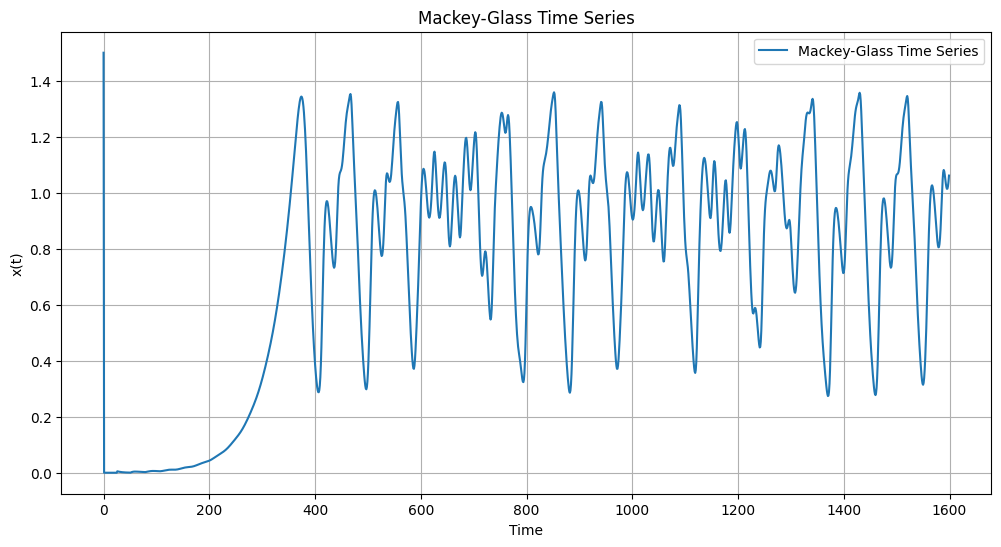

Training data shape: (800, 5) (800,)
Validation data shape: (200, 5) (200,)
Test data shape: (200, 5) (200,)


In [9]:
# Parameters
beta = 0.2
gamma = 0.1
n = 10
tau = 25  # Delay
x0 = 1.5
total_time = 1600

# Generate Mackey-Glass time series
t, x = mackey_glass(total_time, beta, gamma, n, tau, x0)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(t, x, label='Mackey-Glass Time Series')
plt.title('Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)
plt.show()

# Define the time indices for input and output
t_indices = np.arange(301, 1501)  # 301 to 1500 inclusive

# Prepare the input features
inputs = np.column_stack((
    x[t_indices - 20],
    x[t_indices - 15],
    x[t_indices - 10],
    x[t_indices - 5],
    x[t_indices]
))

# Prepare the outputs
outputs = x[t_indices + 5]

# Indices for splitting
train_end = 800
val_end = 1000

# Training data
X_train = inputs[:train_end]
y_train = outputs[:train_end]

# Validation data
X_val = inputs[train_end:val_end]
y_val = outputs[train_end:val_end]

# Test data
X_test = inputs[val_end:]
y_test = outputs[val_end:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

In [22]:

# Define the model
model = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", val_mse)

# Test the model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

Validation MSE: 0.012758341897515995
Test MSE: 0.020014036349930188


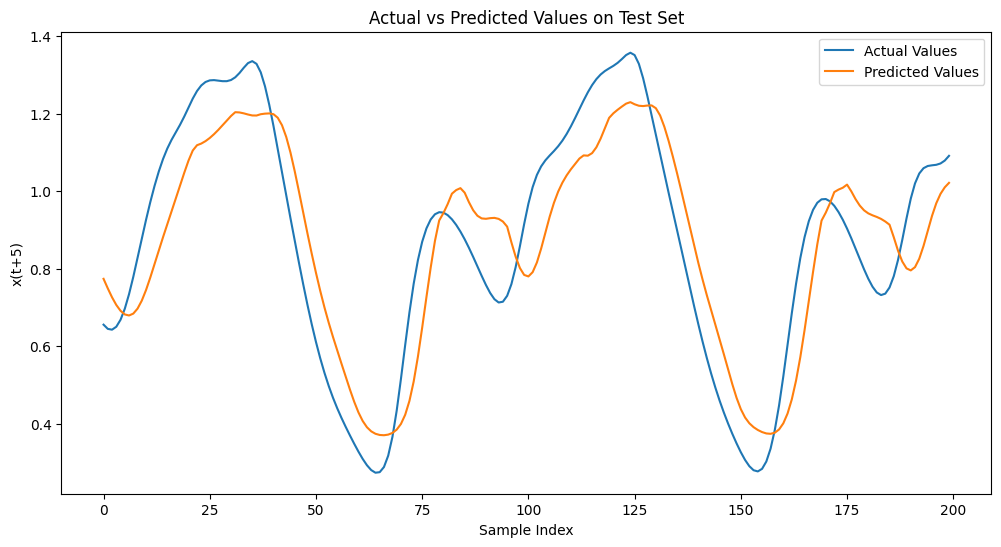

In [23]:


# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values')
plt.plot(range(len(y_test_pred)), y_test_pred, label='Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('x(t+5)')
plt.legend()
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scaler on training data and transform
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Reshape y for scaler
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit scaler on training outputs and transform
y_train_scaled = scaler_y.fit_transform(y_train).flatten()
y_val_scaled = scaler_y.transform(y_val).flatten()
y_test_scaled = scaler_y.transform(y_test).flatten()

In [11]:
def build_and_train_model(hidden_layers, activation_functions, l2_lambda, learning_rate, batch_size, epochs, use_early_stopping):
    # Clear any existing models to free up resources
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.Input(shape=(X_train_scaled.shape[1],)))
    
    # Hidden layers
    for units, activation in zip(hidden_layers, activation_functions):
        model.add(tf.keras.layers.Dense(units, activation=activation, 
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
                                        kernel_initializer='glorot_uniform'))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    
    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)  # Use SGD as per assignment
    model.compile(optimizer=optimizer, loss='mse')
    
    # Callbacks
    callbacks = []
    
    # Early Stopping callback
    if use_early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=30, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0  # Set to 1 for detailed logs
    )
    
    # Calculate training MSE
    y_train_pred_scaled = model.predict(X_train_scaled).flatten()
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    train_mse = mean_squared_error(y_train.flatten(), y_train_pred)
    
    # Calculate test MSE
    y_test_pred_scaled = model.predict(X_test_scaled).flatten()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    test_mse = mean_squared_error(y_test.flatten(), y_test_pred)
    
    return history, train_mse, test_mse, model

In [26]:
# Define hyperparameters
hidden_layers = [9, 9]
activation_functions = ['sigmoid', 'sigmoid']
l2_lambda_0 = 0.00
learning_rate = 0.05
batch_size = len(X_train_scaled)
epochs_1 = 1000
epochs_2 = 1000
no_use_early_stopping = False
use_early_stopping = True


# Train the model
history, train_mse, test_mse, model = build_and_train_model(
    hidden_layers,
    activation_functions,
    l2_lambda_0,
    learning_rate,
    batch_size,
    epochs_1,
    no_use_early_stopping
)

history2, train_mse2, test_mse2, model2 = build_and_train_model(
    hidden_layers,
    activation_functions,
    l2_lambda_0,
    learning_rate,
    batch_size,
    epochs_2,
    use_early_stopping
)

# Print results
print(f"Training MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

print(f"Training MSE with early stopping: {train_mse2:.6f}")
print(f"Test MSE with early stopping: {test_mse2:.6f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Training MSE: 0.007960
Test MSE: 0.007761
Training MSE with early stopping: 0.009471
Test MSE with early stopping: 0.008602


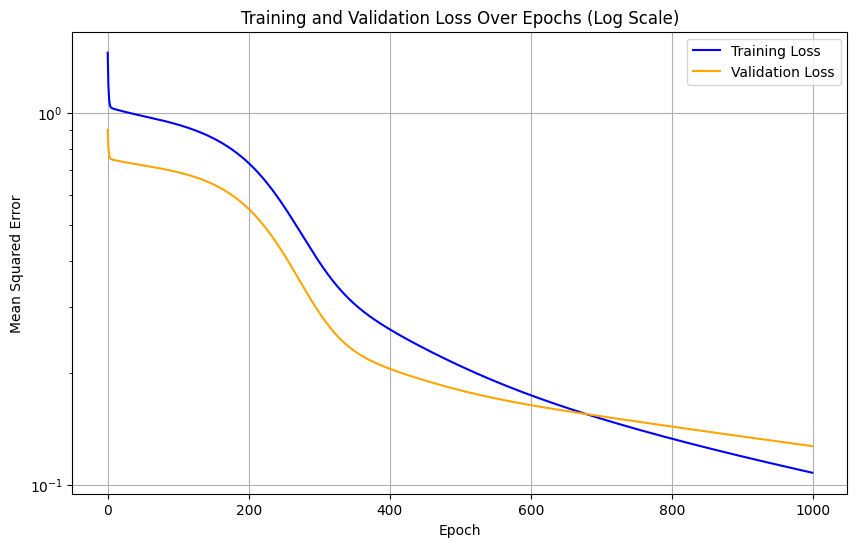

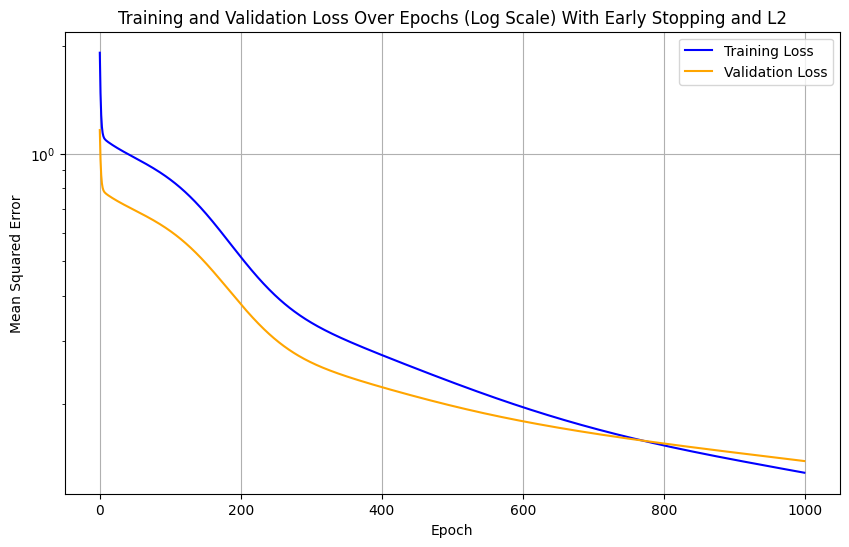

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (Log Scale) With Early Stopping and L2')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


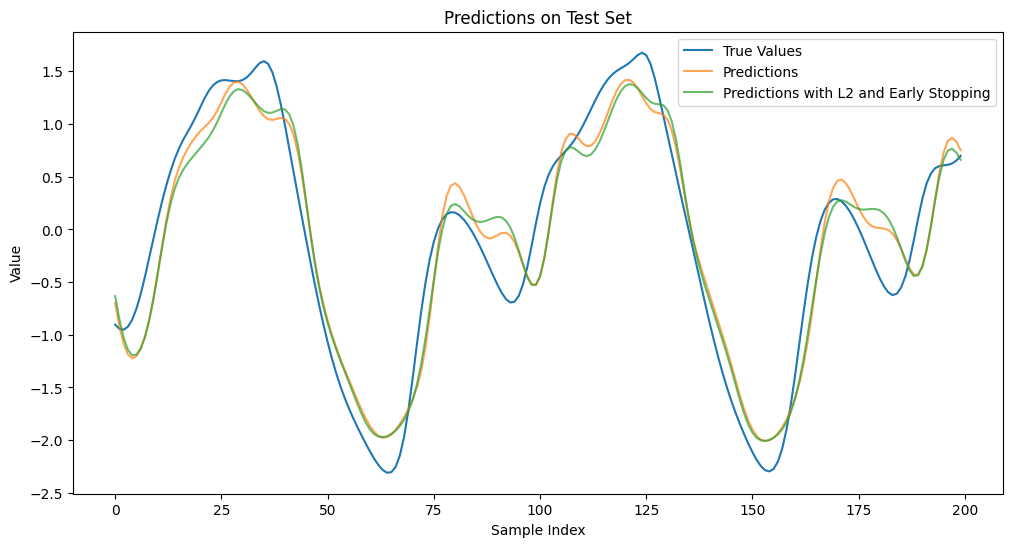

In [28]:
y_test_pred = model.predict(X_test_scaled).flatten()
y_test_pred2 = model2.predict(X_test_scaled).flatten()

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='True Values')
plt.plot(y_test_pred, label='Predictions', alpha=0.7)
plt.plot(y_test_pred2, label='Predictions with L2 and Early Stopping', alpha=0.7)
plt.title('Predictions on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [29]:
# Define hyperparameter grid
nh1_options = [3, 4, 5]
nh2_options = [2, 4, 6]
hidden_layer_combinations = list(itertools.product(nh1_options, nh2_options))

learning_rates = [0.05]
l2_lambdas = [0.001]
batch_sizes = [len(X_train_scaled)]  # Full-batch gradient descent

num_runs = 5  # Number of times to run each configuration

# Store results
results = []

# Define other hyperparameters
activation_functions = ['sigmoid', 'sigmoid']
epochs = 2000  

# Perform grid search with multiple runs
for hidden_layers in hidden_layer_combinations:
    for lr in learning_rates:
        for l2 in l2_lambdas:
            for batch_size in batch_sizes:
                print(f"Training with hidden_layers={hidden_layers}, lr={lr}, l2_lambda={l2}, batch_size={batch_size}")
                
                # Lists to store MSEs for each run
                train_mse_runs = []
                val_mse_runs = []
                test_mse_runs = []
                
                for run in range(1, num_runs + 1):
                    print(f"  Run {run}/{num_runs}")
                    
                    # Optionally, set a different random seed for each run to ensure different weight initializations
                    # For true randomness, you can skip setting the seed
                    # Alternatively, set seeds based on run number
                    seed = 42 + run  # Example: 43, 44, ..., 47
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    
                    history, train_mse, test_mse, model = build_and_train_model(
                        hidden_layers=hidden_layers,
                        activation_functions=activation_functions,
                        l2_lambda=l2,
                        learning_rate=lr,
                        batch_size=batch_size,
                        epochs=epochs,
                        use_early_stopping=True
                    )
                    
                    # Extract the minimum validation MSE from history
                    val_mse = min(history.history['val_loss'])
                    
                    # Append MSEs to lists
                    train_mse_runs.append(train_mse)
                    val_mse_runs.append(val_mse)
                    test_mse_runs.append(test_mse)
                    
                    print(f"    Run {run} - Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, Test MSE: {test_mse:.6f}")
                
                # After all runs, compute mean and variance
                train_mse_mean = np.mean(train_mse_runs)
                train_mse_var = np.var(train_mse_runs)
                val_mse_mean = np.mean(val_mse_runs)
                val_mse_var = np.var(val_mse_runs)
                test_mse_mean = np.mean(test_mse_runs)
                test_mse_var = np.var(test_mse_runs)
                
                # Store the aggregated results
                results.append({
                    'hidden_layers': hidden_layers,
                    'learning_rate': lr,
                    'l2_lambda': l2,
                    'batch_size': batch_size,
                    'train_mse_mean': train_mse_mean,
                    'train_mse_var': train_mse_var,
                    'val_mse_mean': val_mse_mean,
                    'val_mse_var': val_mse_var,
                    'test_mse_mean': test_mse_mean,
                    'test_mse_var': test_mse_var
                })
                
                print(f"  Completed hidden_layers={hidden_layers} - Avg Train MSE: {train_mse_mean:.6f} (Var: {train_mse_var:.6f}), "
                      f"Avg Val MSE: {val_mse_mean:.6f} (Var: {val_mse_var:.6f}), Avg Test MSE: {test_mse_mean:.6f} (Var: {test_mse_var:.6f})\n")


Training with hidden_layers=(3, 2), lr=0.05, l2_lambda=0.001, batch_size=800
  Run 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 1 - Train MSE: 0.008398, Val MSE: 0.141036, Test MSE: 0.007518
  Run 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 2 - Train MSE: 0.002865, Val MSE: 0.068295, Test MSE: 0.002536
  Run 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 3 - Train MSE: 0.003855, Val MSE: 0.074846, Test MSE: 0.003843
  Run 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 4 - Train MSE: 0.003623, Val MSE: 0.084938, Test MSE: 0.003742
  Run 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
    Run 5 - Train MSE: 0.001837, Val MSE: 0.056233, Test MSE: 0.002141
  Completed hidden_layers=(3, 2) - Avg Train MSE: 0.004116 (Var: 0.000005), Avg Val MSE: 0.085070 (Var: 0.000870), Avg Test MSE:


Grid Search Results with Averages and Variances:
  hidden_layers  learning_rate  l2_lambda  batch_size  train_mse_mean  \
0        (3, 2)           0.05      0.001         800        0.004116   
1        (3, 4)           0.05      0.001         800        0.004228   
2        (3, 6)           0.05      0.001         800        0.002938   
3        (4, 2)           0.05      0.001         800        0.004334   
4        (4, 4)           0.05      0.001         800        0.004702   
5        (4, 6)           0.05      0.001         800        0.003325   
6        (5, 2)           0.05      0.001         800        0.003358   
7        (5, 4)           0.05      0.001         800        0.003011   
8        (5, 6)           0.05      0.001         800        0.003844   

   train_mse_var  val_mse_mean  val_mse_var  test_mse_mean  test_mse_var  
0   5.081737e-06      0.085070     0.000870       0.003956  3.611001e-06  
1   5.692390e-06      0.094852     0.001461       0.004355  7.359155e

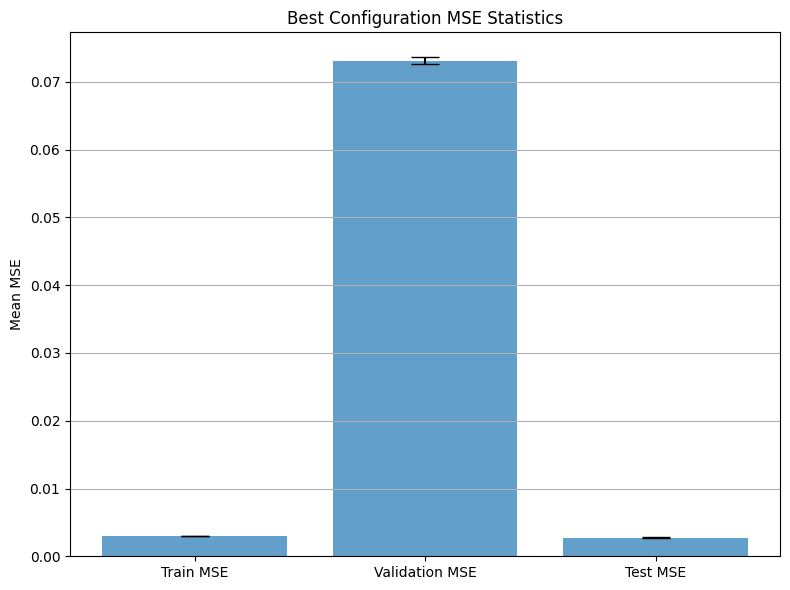

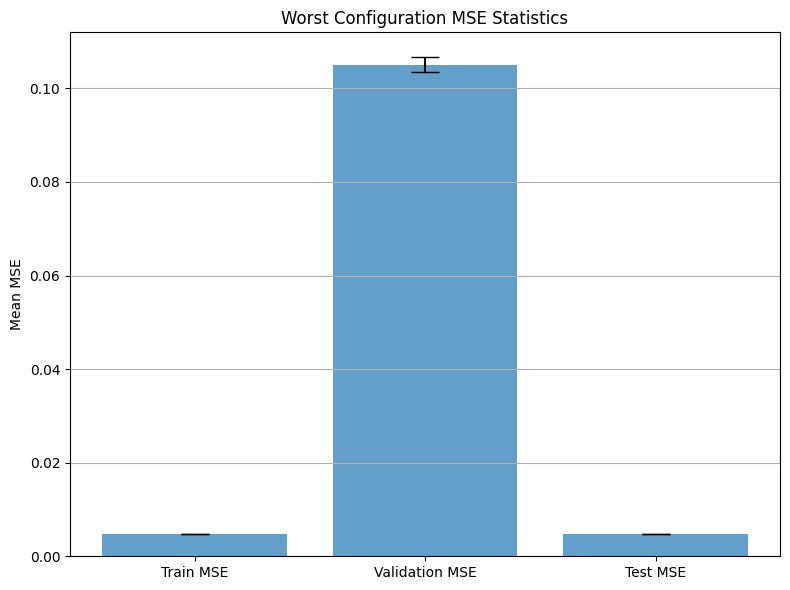

In [30]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\nGrid Search Results with Averages and Variances:")
print(results_df)

# Identify the best and worst configurations based on average validation MSE
best_config = results_df.loc[results_df['val_mse_mean'].idxmin()]
worst_config = results_df.loc[results_df['val_mse_mean'].idxmax()]

print("\nBest Configuration Based on Average Validation MSE:")
print(best_config)

print("\nWorst Configuration Based on Average Validation MSE:")
print(worst_config)

# Function to plot mean and variance
def plot_mse_statistics(config_name, config_series):
    labels = ['Train MSE', 'Validation MSE', 'Test MSE']
    means = [config_series['train_mse_mean'], config_series['val_mse_mean'], config_series['test_mse_mean']]
    variances = [config_series['train_mse_var'], config_series['val_mse_var'], config_series['test_mse_var']]
    
    x_pos = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x_pos, means, yerr=variances, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel('Mean MSE')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(f'{config_name} Configuration MSE Statistics')
    ax.yaxis.grid(True)
    
    # Save the figure
    plt.tight_layout()
    plt.show()

# Plot for Best Configuration
plot_mse_statistics('Best', best_config)

# Plot for Worst Configuration
plot_mse_statistics('Worst', worst_config)

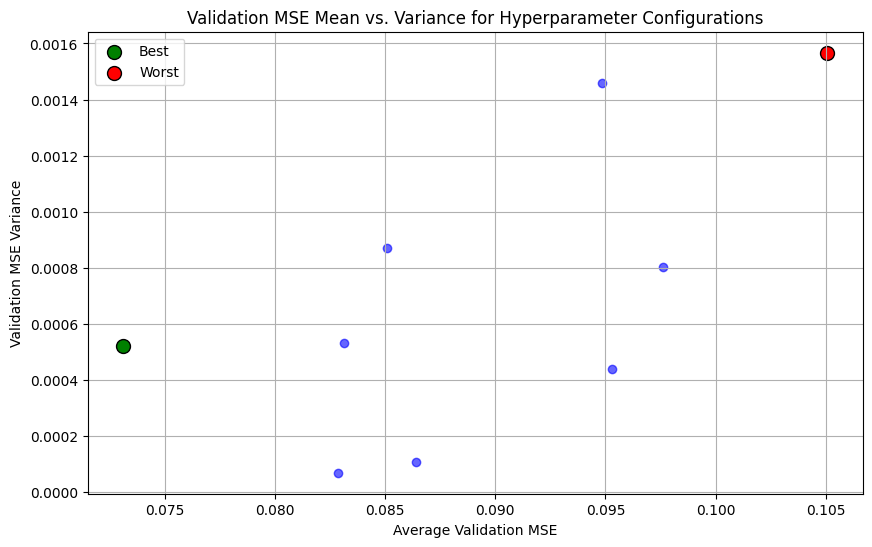

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['val_mse_mean'], results_df['val_mse_var'], color='blue', alpha=0.6)

# Highlight Best and Worst
plt.scatter(best_config['val_mse_mean'], best_config['val_mse_var'], color='green', label='Best', s=100, edgecolors='black')
plt.scatter(worst_config['val_mse_mean'], worst_config['val_mse_var'], color='red', label='Worst', s=100, edgecolors='black')

plt.xlabel('Average Validation MSE')
plt.ylabel('Validation MSE Variance')
plt.title('Validation MSE Mean vs. Variance for Hyperparameter Configurations')
plt.legend()
plt.grid(True)
plt.show()

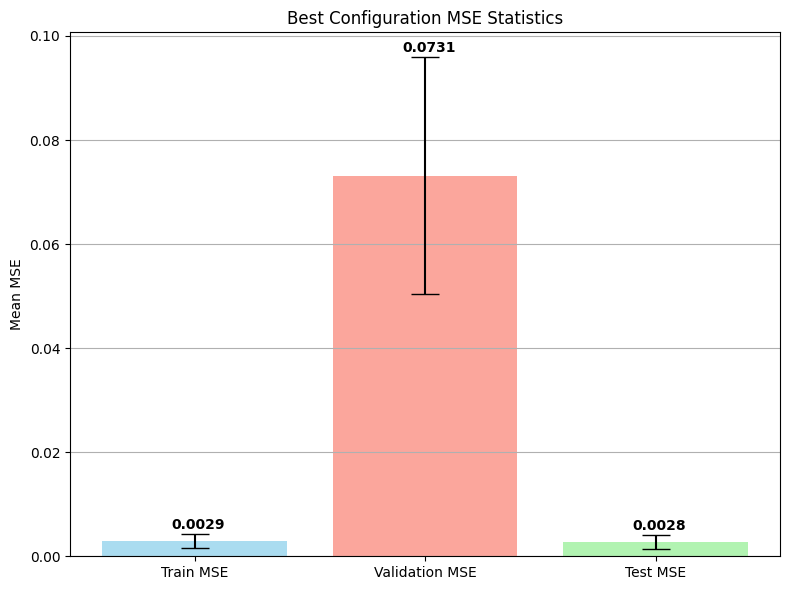

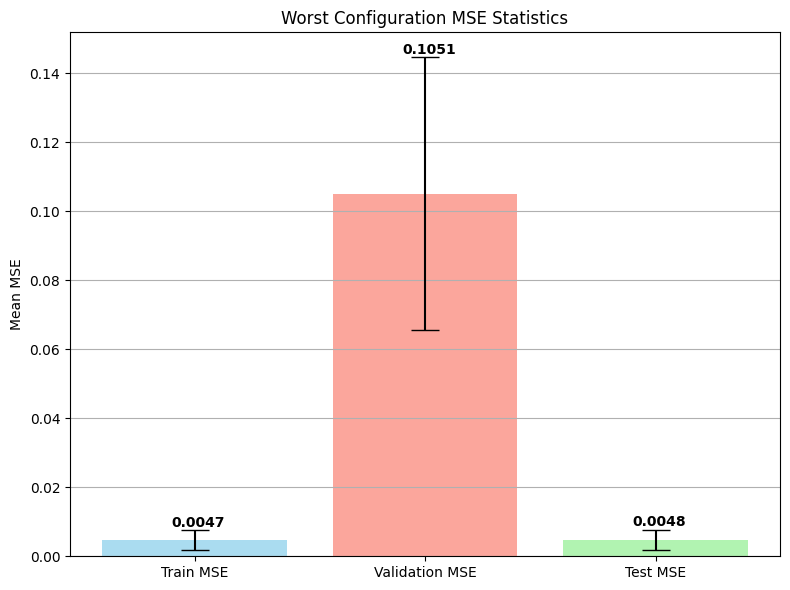

In [34]:
# Updated plotting function using bar plots with error bars
def plot_mse_statistics(config_name, config_series):
    labels = ['Train MSE', 'Validation MSE', 'Test MSE']
    means = [
        config_series['train_mse_mean'], 
        config_series['val_mse_mean'], 
        config_series['test_mse_mean']
    ]
    std_devs = [
        np.sqrt(config_series['train_mse_var']), 
        np.sqrt(config_series['val_mse_var']), 
        np.sqrt(config_series['test_mse_var'])
    ]
    
    x_pos = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, 
           ecolor='black', capsize=10, color=['skyblue', 'salmon', 'lightgreen'])
    ax.set_ylabel('Mean MSE')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(f'{config_name} Configuration MSE Statistics')
    ax.yaxis.grid(True)
    
    # Annotate bars with mean values
    for i, v in enumerate(means):
        ax.text(x_pos[i] - 0.1, v + std_devs[i] + 0.001, f"{v:.4f}", color='black', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot for Best Configuration
plot_mse_statistics('Best', best_config)

# Plot for Worst Configuration
plot_mse_statistics('Worst', worst_config)

In [35]:
# Define hyperparameter grid
nh1_options = [3]
nh2_options = [6]
hidden_layer_combinations = list(itertools.product(nh1_options, nh2_options))

learning_rates = [0.1, 0.05, 0.01]
l2_lambdas = [0.001, 0.0001, 0.01]
batch_sizes = [len(X_train_scaled)]  # Full-batch gradient descent

num_runs = 5  # Number of times to run each configuration

# Store results
results_config = []

# Define other hyperparameters
activation_functions = ['sigmoid', 'sigmoid']
epochs = 2000  

# Perform grid search with multiple runs
for hidden_layers in hidden_layer_combinations:
    for lr in learning_rates:
        for l2 in l2_lambdas:
            for batch_size in batch_sizes:
                print(f"Training with hidden_layers={hidden_layers}, lr={lr}, l2_lambda={l2}, batch_size={batch_size}")
                
                # Lists to store MSEs for each run
                train_mse_runs = []
                val_mse_runs = []
                test_mse_runs = []
                
                for run in range(1, num_runs + 1):
                    print(f"  Run {run}/{num_runs}")
                    
                    # Optionally, set a different random seed for each run to ensure different weight initializations
                    # For true randomness, you can skip setting the seed
                    # Alternatively, set seeds based on run number
                    seed = 42 + run  # Example: 43, 44, ..., 47
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    
                    history, train_mse, test_mse, model = build_and_train_model(
                        hidden_layers=hidden_layers,
                        activation_functions=activation_functions,
                        l2_lambda=l2,
                        learning_rate=lr,
                        batch_size=batch_size,
                        epochs=epochs,
                        use_early_stopping=True
                    )
                    
                    # Extract the minimum validation MSE from history
                    val_mse = min(history.history['val_loss'])
                    
                    # Append MSEs to lists
                    train_mse_runs.append(train_mse)
                    val_mse_runs.append(val_mse)
                    test_mse_runs.append(test_mse)
                    
                    print(f"    Run {run} - Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}, Test MSE: {test_mse:.6f}")
                
                # After all runs, compute mean and variance
                train_mse_mean = np.mean(train_mse_runs)
                train_mse_var = np.var(train_mse_runs)
                val_mse_mean = np.mean(val_mse_runs)
                val_mse_var = np.var(val_mse_runs)
                test_mse_mean = np.mean(test_mse_runs)
                test_mse_var = np.var(test_mse_runs)
                
                # Store the aggregated results
                results_config.append({
                    'hidden_layers': hidden_layers,
                    'learning_rate': lr,
                    'l2_lambda': l2,
                    'batch_size': batch_size,
                    'train_mse_mean': train_mse_mean,
                    'train_mse_var': train_mse_var,
                    'val_mse_mean': val_mse_mean,
                    'val_mse_var': val_mse_var,
                    'test_mse_mean': test_mse_mean,
                    'test_mse_var': test_mse_var
                })
                
                print(f"  Completed hidden_layers={hidden_layers} - Avg Train MSE: {train_mse_mean:.6f} (Var: {train_mse_var:.6f}), "
                      f"Avg Val MSE: {val_mse_mean:.6f} (Var: {val_mse_var:.6f}), Avg Test MSE: {test_mse_mean:.6f} (Var: {test_mse_var:.6f})\n")



Training with hidden_layers=(3, 6), lr=0.1, l2_lambda=0.001, batch_size=800
  Run 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 1 - Train MSE: 0.001122, Val MSE: 0.047216, Test MSE: 0.001073
  Run 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
    Run 2 - Train MSE: 0.001087, Val MSE: 0.046545, Test MSE: 0.001065
  Run 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 3 - Train MSE: 0.001295, Val MSE: 0.048741, Test MSE: 0.001328
  Run 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 4 - Train MSE: 0.001616, Val MSE: 0.059379, Test MSE: 0.001731
  Run 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
    Run 5 - Train MSE: 0.001064, Val MSE: 0.045813, Test MSE: 0.001058
  Completed hidden_layers=(3, 6) - Avg Train MSE: 0.001237 (Var: 0.000000), Avg Val MSE: 0.049539 (Var: 0.000025), Avg Test MSE: 


Grid Search Results with Averages and Variances:
  hidden_layers  learning_rate  l2_lambda  batch_size  train_mse_mean  \
0        (3, 6)           0.10     0.0010         800        0.001237   
1        (3, 6)           0.10     0.0001         800        0.001225   
2        (3, 6)           0.10     0.0100         800        0.002926   
3        (3, 6)           0.05     0.0010         800        0.002938   
4        (3, 6)           0.05     0.0001         800        0.002794   
5        (3, 6)           0.05     0.0100         800        0.007325   
6        (3, 6)           0.01     0.0010         800        0.025527   
7        (3, 6)           0.01     0.0001         800        0.025344   
8        (3, 6)           0.01     0.0100         800        0.028226   

   train_mse_var  val_mse_mean  val_mse_var  test_mse_mean  test_mse_var  
0   4.245866e-08      0.049539     0.000025       0.001251  6.806348e-08  
1   5.275179e-08      0.028925     0.000034       0.001254  1.034827e

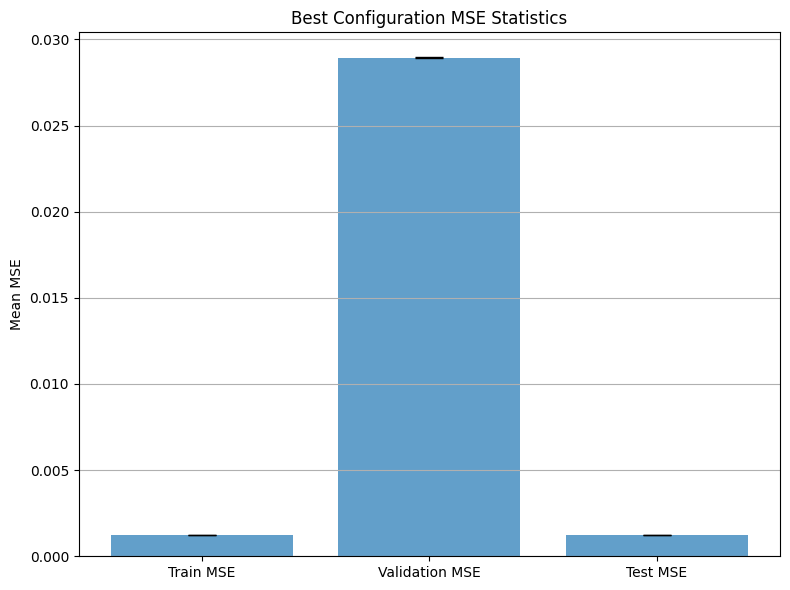

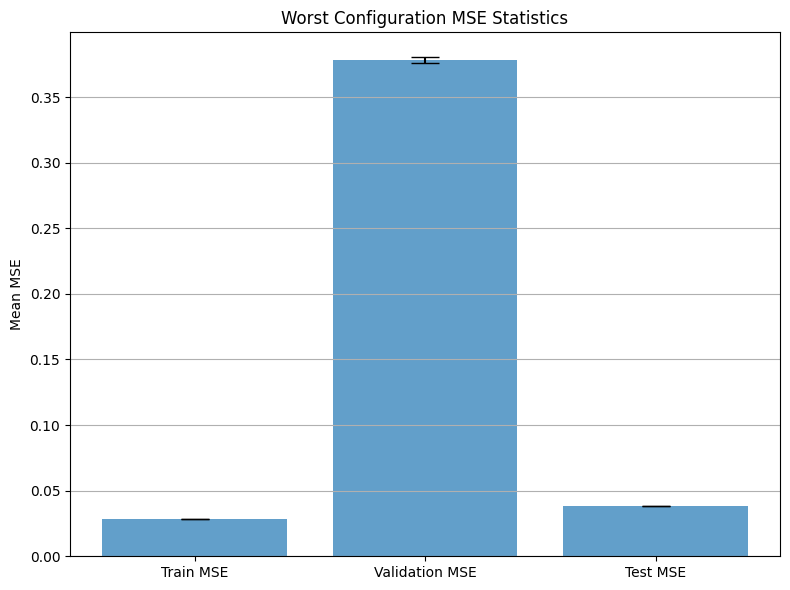

In [37]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_config)

print("\nGrid Search Results with Averages and Variances:")
print(results_df)

# Identify the best and worst configurations based on average validation MSE
best_config = results_df.loc[results_df['val_mse_mean'].idxmin()]
worst_config = results_df.loc[results_df['val_mse_mean'].idxmax()]

print("\nBest Configuration Based on Average Validation MSE:")
print(best_config)

print("\nWorst Configuration Based on Average Validation MSE:")
print(worst_config)

# Function to plot mean and variance
def plot_mse_statistics(config_name, config_series):
    labels = ['Train MSE', 'Validation MSE', 'Test MSE']
    means = [config_series['train_mse_mean'], config_series['val_mse_mean'], config_series['test_mse_mean']]
    variances = [config_series['train_mse_var'], config_series['val_mse_var'], config_series['test_mse_var']]
    
    x_pos = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x_pos, means, yerr=variances, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel('Mean MSE')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(f'{config_name} Configuration MSE Statistics')
    ax.yaxis.grid(True)
    
    # Save the figure
    plt.tight_layout()
    plt.show()

# Plot for Best Configuration
plot_mse_statistics('Best', best_config)

# Plot for Worst Configuration
plot_mse_statistics('Worst', worst_config)

In [12]:
history_best, train_mse_best, test_mse_best, model_best = build_and_train_model(
    hidden_layers=[3,6],
    activation_functions=["sigmoid", "sigmoid"],
    l2_lambda=0.01,
    learning_rate=0.1,
    batch_size=len(X_train_scaled),
    epochs=2000,
    use_early_stopping=True
)

history_worst, train_mse_worst, test_mse_worst, model_worst = build_and_train_model(
    hidden_layers=[4,4],
    activation_functions=["sigmoid", "sigmoid"],
    l2_lambda=0.001,
    learning_rate=0.01,
    batch_size=len(X_train_scaled),
    epochs=2000,
    use_early_stopping=True
)

2024-09-20 12:49:27.993904: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-20 12:49:27.993943: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-20 12:49:27.993958: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-20 12:49:27.994024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-20 12:49:27.994042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-20 12:49:28.427243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


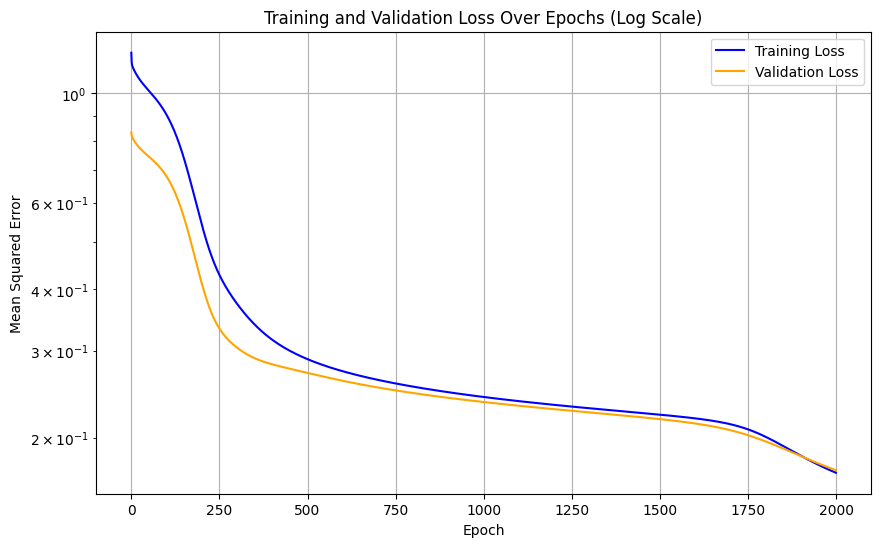

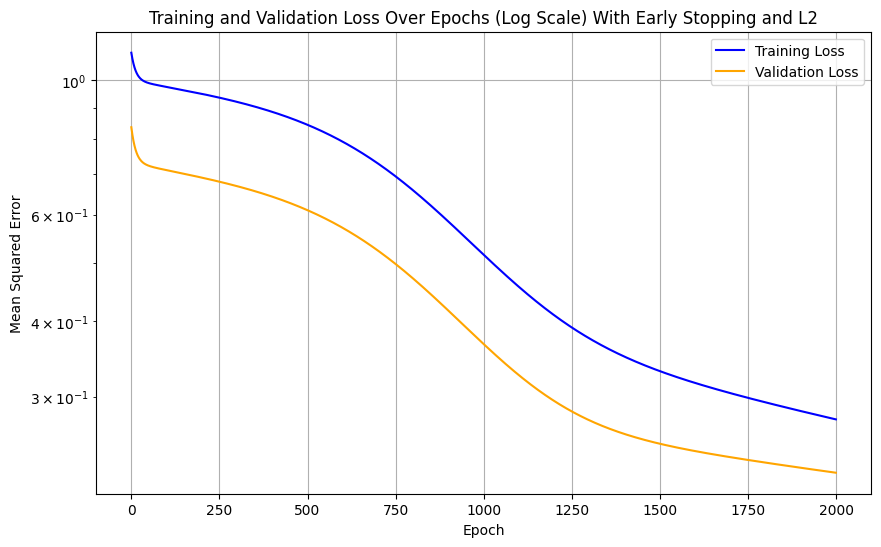

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history_best.history['loss'], label='Training Loss', color='blue')
plt.plot(history_best.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(history_worst.history['loss'], label='Training Loss', color='blue')
plt.plot(history_worst.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (Log Scale) With Early Stopping and L2')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.grid(True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


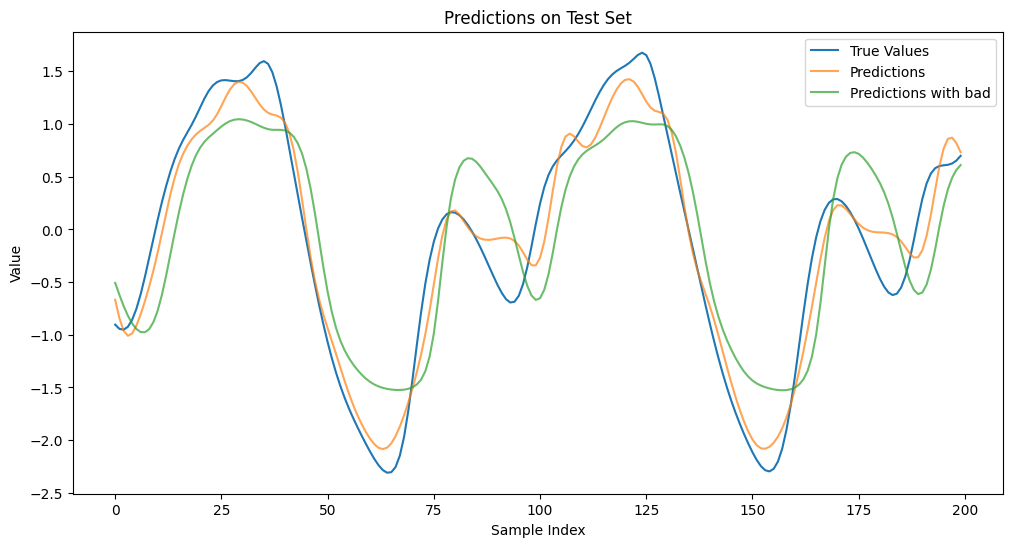

In [15]:
y_test_pred = model_best.predict(X_test_scaled).flatten()
y_test_pred2 = model_worst.predict(X_test_scaled).flatten()

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='True Values')
plt.plot(y_test_pred, label='Predictions', alpha=0.7)
plt.plot(y_test_pred2, label='Predictions with bad', alpha=0.7)
plt.title('Predictions on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()